# Pseudospectral Method

This notebook presents a Fourier Pseudospectral code for solving the 2D acoustic wave equation.

The problem of solving the wave equation

\begin{equation}
\partial_t^2 p = c^2 (\partial_{x}^{2}p + \partial_{z}^{2}p) + s
\end{equation}

can be achieved using finite differeces in combination with spectral methods. Here, spatial partial derivatives with respect to $x$ and $z$ are computed via the Fourier method, i.e. 

\begin{equation}
\partial_{x}^{2}p + \partial_{z}^{2}p = \mathscr{F}^{-1}[-k_{x}^{2}\mathscr{F}[p]] + \mathscr{F}^{-1}[-k_{z}^{2}\mathscr{F}[p]]
\end{equation}

where $\mathscr{F}$ represents the Fourier transform operator.

We use a standard 3-point finite-difference operator to approximate the time derivatives. Then, the pressure field is extrapolated as

\begin{equation}
\frac{p_{j,k}^{n+1} - 2p_{j,k}^{n} + p_{j,k}^{n-1}}{dt^2}= c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p)_{j,k} + s_{j,k}^{n}
\end{equation}

In [1]:
using Plots
using FFTW

In [2]:
function fourier_derivative_2nd(f, dx)
    
    nx = length(f)
    
    kmax = pi / dx
    
    dk = kmax / (nx / 2) 
    
    k = zeros(nx)
    
    for i in 1 : nx
        
        k[i] = i - 1
        
    end
    
    k[1 : Int(nx/2)] = k[1 : Int(nx/2)] * dk 
    k[Int(nx/2) + 1 : end] = k[1 : Int(nx/2)] .- kmax
    
    # Fourier derivative
    ff = fft(f)
    
    ff = @. (1im * k)^2 * ff
    
    df_num = real(ifft(ff))
    
    return df_num
    
end

fourier_derivative_2nd (generic function with 1 method)

## Parameter configuration 

In [3]:
nx   = 250        # number of grid points in x-direction
nz   = nx           # number of grid points in z-direction

dx   = 2.           # grid point distance in x-direction
dz   = dx           # grid point distance in z-direction
c0   = 580.         # wave velocity in medium (m/s)
isx  = Int(nx/2.5)         # source location in grid in x-direction
isz  = Int(nz/2.5)         # source location in grid in z-direction
nt   = 2500        # maximum number of time steps
dt   = 0.0002       # time step
f0   = 25. # dominant frequency of the source (Hz)
t0   = 2. / f0 # source time shift

eps  = c0 * dt / dx # epsilon value

println("Source frequency =", f0, "Hz")
println("Stability criterion =", eps)
println("Simulated time: ", nt*dt, " s")

Source frequency =25.0Hz
Stability criterion =0.058
Simulated time: 0.5 s


## Pseudospectral method

In [4]:
function pseudospectral_method(nx, nz, nt, dx, dz, dt, c0, isx, isz, f0, t0)

    # Initialize Empty Pressure
    p    = zeros((nz, nx)) # p at time n (now)
    pold = zeros((nz, nx)) # p at time n-1 (past)
    pnew = zeros((nz, nx)) # p at time n+1 (present)

    d2px = zeros((nz, nx)) # 2nd space derivative of p in x-direction
    d2pz = zeros((nz, nx)) # 2nd space derivative of p in z-direction

    # Initialize Velocity Model (assume homogeneous model)
    c = zeros((nz, nx))
    c = c .+ c0             # initialize wave velocity in model

    # Initialize Grid
    x = 1 : nx
    x *= dx             # coordinate in x-direction

    z = 1 : nz
    z *= dz             # coordinate in z-direction

    src  = zeros(nt + 1)

    time = range(0, stop = nt * dt, length=nt)

    src  = @. -8. * (time - t0) * f0 * (exp(-1.0 * (4*f0)^2 * (time - t0)^2))

    for it in 1 : nt
            
        for i in 1 : nx
            
            d2px[i, :] = fourier_derivative_2nd(p[i, :], dx)
            
        end
        
        for j in 1 : nz    
            
            d2pz[:, j] = fourier_derivative_2nd(p[:,j], dz) 
            
        end


        pnew = @. 2 * p - pold + c^2 * dt^2 * (d2pz + d2px)

        pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt^2) 

        pold, p = p, pnew

    end

    return p
    
end

pseudospectral_method (generic function with 1 method)

In [5]:
result = @time pseudospectral_method(nx, nz, nt, dx, dz, dt, c0, isx, isz, f0, t0);

 48.836588 seconds (158.34 M allocations: 39.863 GiB, 18.34% gc time)


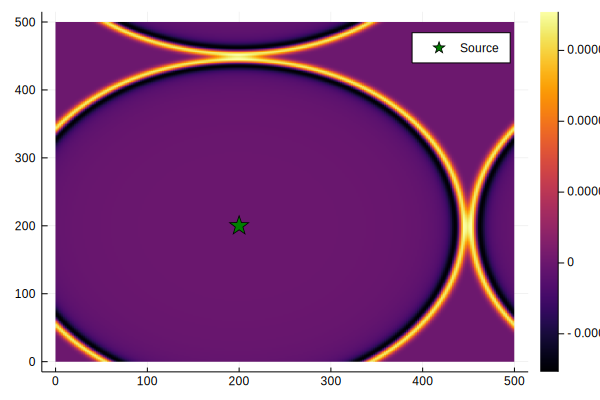

In [6]:
heatmap(1:dx:dx*nx, 1:dz:dz*nz, result)
scatter!([isx*dx], [isz*dz], color=:green, label="Source", m=:star, markersize=10)